In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import pickle

This is the hands-on part of the midterm. You are asked to train and build a machine learning model using GitHub Actions for CI/CD deployment on Heroku.

 Problem: Use the Student Performance in the test dataset in Kaggle:

https://www.kaggle.com/datasets/spscientist/students-performance-in-exams

To predict race/ethnicity of the student from the math, reading and writing scores. Use any model training algorithm you like, accuracy is important, but not essential. Creating the index.html and app.py for receiving user input and processing it respectively. Focus on setting up the CI/CD pipeline and deployment on Heroku.

Submit GitHub repository for your project and Heroku URLs.

In [2]:
df = pd.read_csv("Data/StudentsPerformance.csv")
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


In [3]:
df.shape

(1000, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


**Check for missing values**

In [5]:
print(df.isnull().sum().sort_values(ascending=False).to_string())

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0


In [6]:
# Duplicate row check
df.duplicated().sum()

0

**Rename Columns with spaces**

In [7]:
df = df.rename(columns={'race/ethnicity':'race'})
df = df.rename(columns={'parental level of education':'parent_ed'})
df = df.rename(columns={'test preparation course':'test_prep_course'})
df = df.rename(columns={'math score':'math_score'})
df = df.rename(columns={'reading score':'reading_score'})
df = df.rename(columns={'writing score':'writing_score'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   gender            1000 non-null   object
 1   race              1000 non-null   object
 2   parent_ed         1000 non-null   object
 3   lunch             1000 non-null   object
 4   test_prep_course  1000 non-null   object
 5   math_score        1000 non-null   int64 
 6   reading_score     1000 non-null   int64 
 7   writing_score     1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [8]:
df.describe().round(2).transpose()

,count,mean,std,min,25%,50%,75%,max
math_score,1000.0,66.09,15.16,0.0,57.00,66.0,77.0,100.0
reading_score,1000.0,69.17,14.60,17.0,59.00,70.0,79.0,100.0
writing_score,1000.0,68.05,15.20,10.0,57.75,69.0,79.0,100.0


**Visualizations**

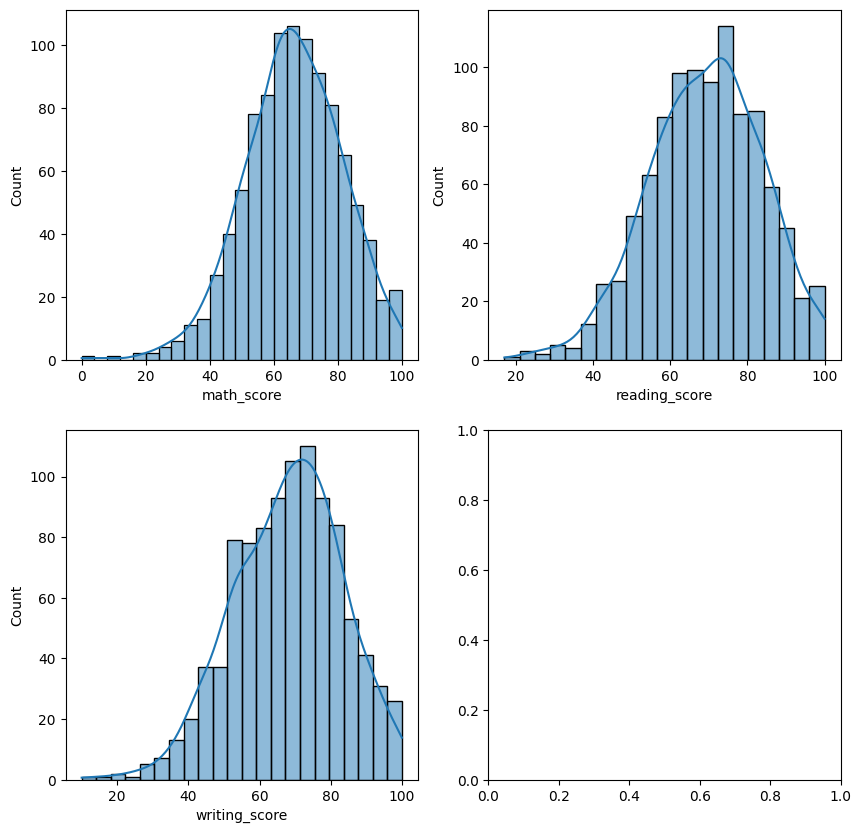

In [12]:
# select the columns to be plotted
cols = df[['math_score','reading_score','writing_score']]

# create the figure and axes
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(10, 10)  # ( x , y )
axes = axes.ravel()  # flattening the array makes indexing easier
for col, ax in zip(cols, axes):
    sns.histplot(data=df[col], kde=True, ax = ax)

plt.show()

**Categorical Value Encoding and Model DataFrame Creation based on chi values**

In [13]:
# Transform categorical to binary Male:0/Female:1
df['gender'] = df['gender'].map({'male': 0, 'female': 1})

# Transform categorical to binary Male:0/Female:1
df['race'] = df['race'].map({'group A': 0, 'group B': 1, 'group C': 2, 'group D': 3, 'group E': 4})

df

,gender,race,parent_ed,lunch,test_prep_course,math_score,reading_score,writing_score
0,1,1,bachelor's degree,standard,none,72,72,74
1,1,2,some college,standard,completed,69,90,88
2,1,1,master's degree,standard,none,90,95,93
3,0,0,associate's degree,free/reduced,none,47,57,44
4,0,2,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,1,4,master's degree,standard,completed,88,99,95
996,0,2,high school,free/reduced,none,62,55,55
997,1,2,high school,free/reduced,completed,59,71,65
998,1,3,some college,standard,completed,68,78,77


In [14]:
y = df['race']
df_model = df[['reading_score','math_score','writing_score']].copy()
df_model

,reading_score,math_score,writing_score
0,72,72,74
1,90,69,88
2,95,90,93
3,57,47,44
4,78,76,75
...,...,...,...
995,99,88,95
996,55,62,55
997,71,59,65
998,78,68,77


## Modeling

In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_model.values,y)

In [16]:
if isinstance(X_train, pd.DataFrame):
    print('DType:\nX_train:{}, y_train:{}\nShape:\nX_train:{}, y_train:{}\nType:\nX_train:{}, y_train{}'
          .format(type(X_train),type(y_train),X_train.shape,y_train.shape,type(X_train),type(y_train)))
else:
    print('DType:\nX_train:{}, y_train:{}\nShape:\nX_train:{}, y_train:{}\nType:\nX_train:{}, y_train{}'
        .format(X_train.dtype,y_train.dtype,X_train.shape,y_train.shape,type(X_train),type(y_train)))
       

DType:
X_train:int64, y_train:int64
Shape:
X_train:(750, 3), y_train:(750,)
Type:
X_train:<class 'numpy.ndarray'>, y_train<class 'pandas.core.series.Series'>


### Logistic Regression

In [17]:
# Model Original
lgreg = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=10000)
lgreg.fit(X_train, y_train)
y_pred = lgreg.predict(X_test)

In [18]:
# Metrics
cm = confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00        46
           2       0.36      0.56      0.44        90
           3       0.22      0.41      0.29        51
           4       0.33      0.14      0.19        44

    accuracy                           0.31       250
   macro avg       0.18      0.22      0.18       250
weighted avg       0.24      0.31      0.25       250



/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot: >

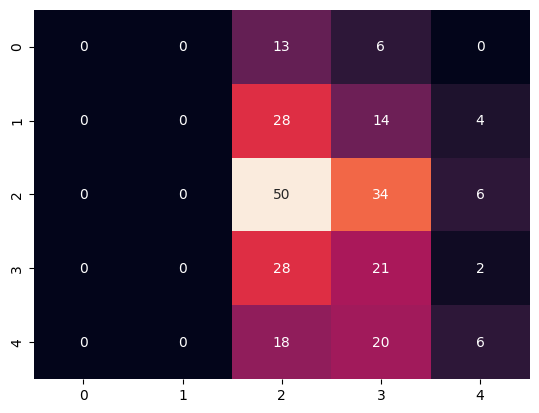

In [19]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, cbar=False)

### KNN

In [20]:
# Logistics Reg Performed better with out scaling
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Model Original Data
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [21]:
# Metrics
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.25      0.30      0.27        46
           2       0.36      0.32      0.34        90
           3       0.19      0.29      0.23        51
           4       0.33      0.07      0.11        44

    accuracy                           0.24       250
   macro avg       0.23      0.20      0.19       250
weighted avg       0.27      0.24      0.24       250



<AxesSubplot: >

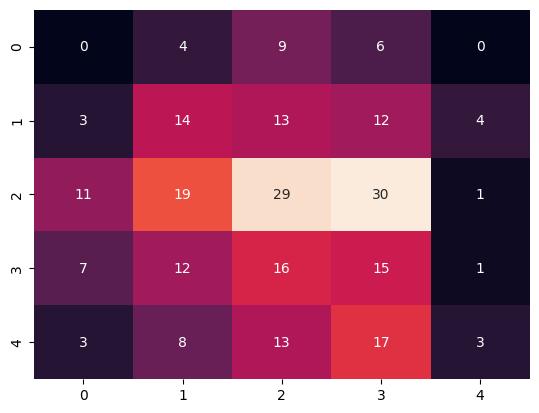

In [22]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, cbar=False)

### Linear SVM (kernel = linear)

In [43]:
svm_linear = SVC(kernel='linear')
svm_linear.fit(X_train, y_train)
y_pred = svm_linear.predict(X_test)

In [42]:
with open('Pickle/test_score','wb') as file:
    pickle.dump(svm_linear,file)

In [44]:
# Metrics
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00        46
           2       0.39      0.70      0.50        90
           3       0.24      0.41      0.30        51
           4       0.00      0.00      0.00        44

    accuracy                           0.34       250
   macro avg       0.13      0.22      0.16       250
weighted avg       0.19      0.34      0.24       250



/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot: >

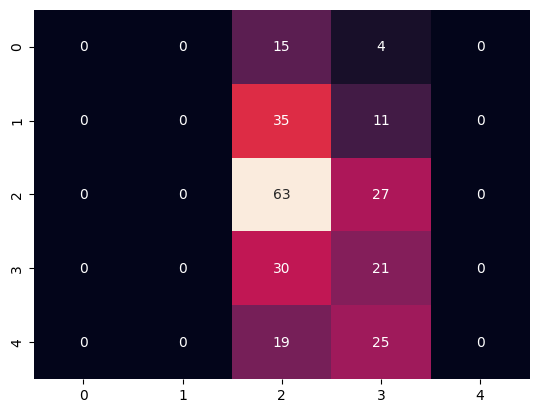

In [25]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, cbar=False)

### Linear SVM (kernel = rbf)

In [26]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [27]:
# Metrics
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.00      0.00      0.00        46
           2       0.38      0.60      0.46        90
           3       0.22      0.43      0.29        51
           4       0.50      0.07      0.12        44

    accuracy                           0.32       250
   macro avg       0.22      0.22      0.17       250
weighted avg       0.27      0.32      0.25       250



/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot: >

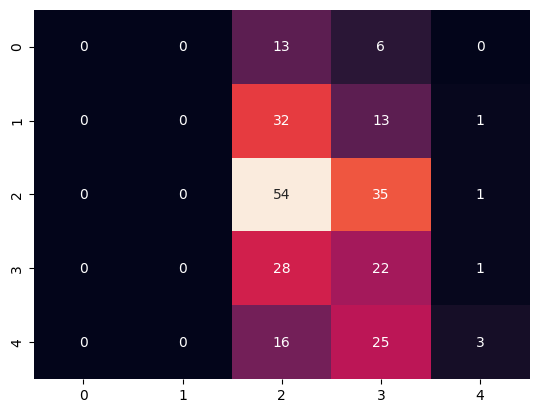

In [28]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, cbar=False)

### Naive Bayes

In [29]:
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

In [30]:
# Metrics
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.20      0.11      0.14        19
           1       0.00      0.00      0.00        46
           2       0.34      0.34      0.34        90
           3       0.24      0.55      0.33        51
           4       0.40      0.27      0.32        44

    accuracy                           0.29       250
   macro avg       0.23      0.25      0.23       250
weighted avg       0.26      0.29      0.26       250



/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot: >

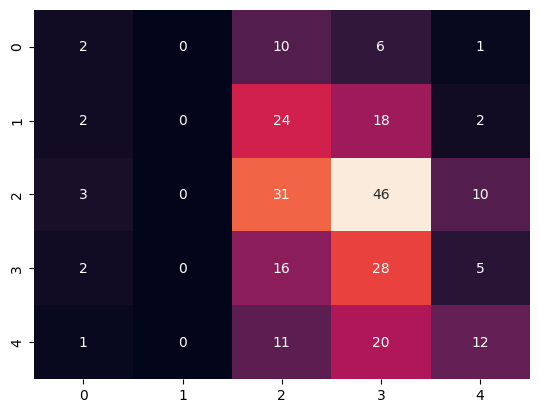

In [31]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, cbar=False)

### Decision Tree

In [32]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [33]:
# Metrics
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.18      0.17      0.18        46
           2       0.30      0.21      0.25        90
           3       0.22      0.39      0.28        51
           4       0.30      0.20      0.24        44

    accuracy                           0.22       250
   macro avg       0.20      0.20      0.19       250
weighted avg       0.24      0.22      0.22       250



<AxesSubplot: >

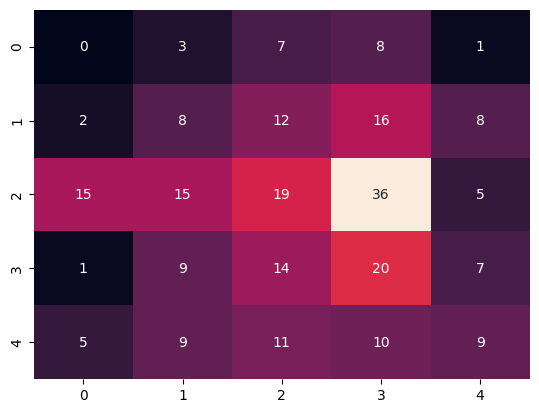

In [34]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, cbar=False)

### Random Forest (estimators = 10)

In [35]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [36]:
# Metrics
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.20      0.20      0.20        46
           2       0.36      0.31      0.33        90
           3       0.27      0.47      0.35        51
           4       0.28      0.16      0.20        44

    accuracy                           0.27       250
   macro avg       0.22      0.23      0.22       250
weighted avg       0.27      0.27      0.26       250



<AxesSubplot: >

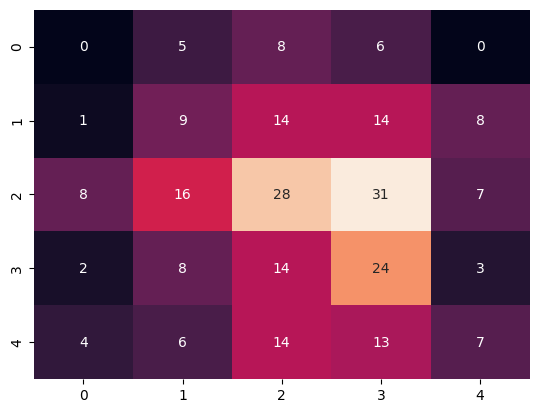

In [37]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, cbar=False)

### XGBoost

In [38]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [39]:
# Metrics
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.11      0.09      0.10        46
           2       0.33      0.31      0.32        90
           3       0.27      0.47      0.35        51
           4       0.21      0.14      0.16        44

    accuracy                           0.25       250
   macro avg       0.18      0.20      0.19       250
weighted avg       0.23      0.25      0.23       250



<AxesSubplot: >

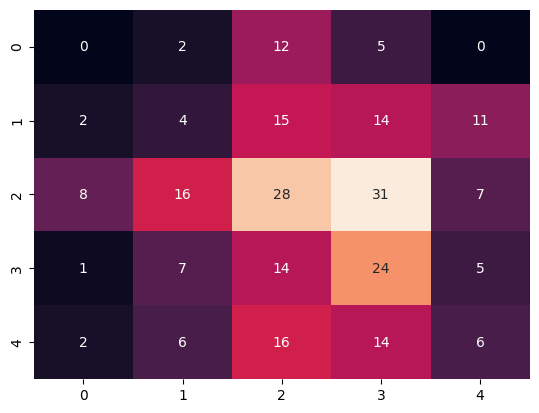

In [40]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True, cbar=False)